In [1]:

import time
import dateparser
import pytz
import json

from datetime import datetime

from binance.client import Client
client = Client("", "")

In [223]:
import numpy as np
import pandas as pd
import pickle

In [224]:
import matplotlib.pyplot as plt


<h5>Helper function that downloads and caches ticker information from the Binance API</h5>
<h5>
This function will allow us to download live ticker data from the Binance API. We specify the symbol parameter as a ticker pair like 'ETHBTC', time_interval like 'Client.KLINE_INTERVAL_4HOUR' and start_time/end_time like '2017-01-01'</h5>

In [5]:

def get_symbol_df(symbol, time_interval, start_time, end_time = None):
    '''Download and cache Binance data for given symbol pair like ETHBTC'''
    
    cache_path = '{} {} {}.pkl'.format(symbol, time_interval, start_time)
    try:
        f = open(cache_path, 'rb')
        data_df = pickle.load(f)
        print('Loaded {} from cache'.format(symbol))
        
    except(OSError, IOError) as e:
        print('Downloading {} from Binance'.format(symbol))
    
        #get symbol data from binance 
        candles = client.get_historical_klines(symbol, time_interval, start_time, end_time)
    
        #labels for dataframe
        labels = ['Open time', 'Open', 'High', 'Low', 'Close', 'Volume', 'Close time', 'Quote asset volume', 'Number of trades',
         'Taker buy base asset volume', 'Taker buy quote asset volume', 'Ignore']

        #populate database with symbols info
        data_df = pd.DataFrame(candles, columns=labels)
    
        #convert timestamp 
        data_df['Open time'] = pd.to_datetime(data_df['Open time'].div(1000), unit='s')
        data_df['Close time'] = pd.to_datetime(data_df['Close time'].div(1000), unit='s')
        
        data_df.to_pickle(cache_path)
        print('Cached {} at {}'.format(symbol, cache_path))
    
    return data_df
 


<h5>Prepare a list of ticker pairs</h5>

In [527]:
def get_all_symbol_pairs(base):
    '''Returns list of symbol pairs for given base
    (would be easy to edit the code to add the most up to date price also)'''
    
    #get live ticker pairs currently listed on binance
    prices = client.get_all_tickers()
    
    symbol_list = []
    for d in prices:
        
        #if trailing 3 characters == base_symbol add the symbol pair and return list
        if(d['symbol'][-3:] == base):
            symbol_list.append(d['symbol'])
            
    return symbol_list

<h5>get a dictionary of specified ticker pairs</h5>

In [542]:
def get_all_symbol_df(base_symbol, time_interval, start_time, end_time = None, add_usd = True):
    '''Returns dictionary of dataframes of symbol pairs'''
    
    #use following line to get an updated list
    symbol_pairs = get_all_symbol_pairs(base_symbol)
    #symbol_pairs = btc_pairs
    
    dict_df = {}
    #get a dataframe of all symbol_pairs populated into a list
    for symbol in symbol_pairs:

        data_df = get_symbol_df(symbol, time_interval, start_time)
        data_df['ticker'] = symbol
        
        #add usd column
        if(add_usd):
            #this runs multi times when it doesn't need to....fix it later
            data_df = get_usd_price(data_df, time_interval)
        
        dict_df[symbol]  = data_df
        
        #####cap data amount for testing purposes. remove later 
        if(len(dict_df) > 10):
            return dict_df
        
    return dict_df

<h5>return USD price of ticker pair</h5>

In [545]:
#BTCUSDT only starts from 2017-08-17 for binance so we lose a month of data, 
#also USDT is not USD. Although it is tethered to USD it deviates depending on supply/demand
#we could pull true USD/BTC rates from other exchanges, but for our MVP this should be fine

def get_usd_price(df, interval):
    '''return df with usdt price added as column'''
    
    btc_usdt = get_symbol_df('BTCUSDT', interval, '2017-01-01')
    btc_usdt = btc_usdt.drop(columns=['Open', 'High', 'Low', 'Volume', 'Close time', 'Quote asset volume',
                                           'Number of trades', 'Taker buy base asset volume', 'Taker buy quote asset volume',
                                           'Ignore'])
    
    #use inner here since usdt data starts on 2018-08-17 and was pulled more recently
    df =df.merge(btc_usdt, left_on='Open time', right_on='Open time', how='inner')
    
    df['Usd'] = round(df['Close_x'].astype(float) * df['Close_y'].astype(float), 2)
    df = df.drop(columns ='Close_y')
    df = df.rename(columns={"Close_x": "Close"})
    
    return df

<h6>With our helper functions setup we can now start downloading BTC pair information. We will start with 4 hour intervals to see if any pump and dumps occur during this time frame.</h6>

In [448]:
#dictionary of all BTC pairs in 4 hour intervals
#key = ticker pair , values = df 
btc_4hour_dict = get_all_symbol_df('BTC', Client.KLINE_INTERVAL_4HOUR, "2017-01-01")

Loaded ETHBTC from cache
Loaded BTCUSDT from cache
Loaded LTCBTC from cache
Loaded BTCUSDT from cache
Loaded BNBBTC from cache
Loaded BTCUSDT from cache
Loaded NEOBTC from cache
Loaded BTCUSDT from cache
Loaded BCCBTC from cache
Loaded BTCUSDT from cache
Loaded GASBTC from cache
Loaded BTCUSDT from cache
Loaded HSRBTC from cache
Loaded BTCUSDT from cache
Loaded MCOBTC from cache
Loaded BTCUSDT from cache
Loaded WTCBTC from cache
Loaded BTCUSDT from cache
Loaded LRCBTC from cache
Loaded BTCUSDT from cache
Loaded QTUMBTC from cache
Loaded BTCUSDT from cache


In [537]:
btc_4hour_dict['ETHBTC'].head()

,Open time,Open,High,Low,Close,Volume,Close time,Quote asset volume,Number of trades,Taker buy base asset volume,Taker buy quote asset volume,Ignore,ticker,Usd
0,2017-08-17 04:00:00,0.07058200,0.07158200,0.06986700,0.07109400,4021.53900000,2017-08-17 07:59:59.999,283.55430669,3117,1950.58800000,137.64451024,46884.54339102,ETHBTC,309.26
1,2017-08-17 08:00:00,0.07088100,0.07122900,0.06883000,0.06940600,3403.20800000,2017-08-17 11:59:59.999,238.55234849,2984,1552.15500000,108.75034780,46866.63079951,ETHBTC,307.28
2,2017-08-17 12:00:00,0.06940600,0.07130400,0.06807700,0.07056100,5091.01200000,2017-08-17 15:59:59.999,353.53825545,4190,2497.76000000,173.62711426,47528.18909052,ETHBTC,307.11
3,2017-08-17 16:00:00,0.07023900,0.07225400,0.06959600,0.07012400,4916.10800000,2017-08-17 19:59:59.999,348.75722631,4351,2317.15100000,164.06176172,48886.75337014,ETHBTC,303.30
4,2017-08-17 20:00:00,0.07012400,0.07147500,0.06988900,0.07047900,3883.15300000,2017-08-17 23:59:59.999,273.59459740,4134,2017.00900000,142.12884692,50579.87228839,ETHBTC,302.01


<h5>Great, we have a dictionary with individual currencies as the value. Next let's define a function to add a pump and dump column to the dataframes.</h5>
<h5>The column will be the difference of the high price minus the close price for the interval</h5>

In [552]:
def add_pnd_column(df, percentage = 0):
    '''add pnd column by High - Close. filter by percentage'''
    
    df['PnD'] = round(df['High'].astype(float)/df['Close'].astype(float) - 1, 4)
    df = df[(df.PnD >= percentage)]
    
    return df

<h5>Here we will define a pump and dump as a spike in price over 10% so let's filter our data to only show 4 hour intervals with 10% spikes or higher.</h5>

In [553]:
#add a pnd column for each df
pnd_4hour = {}
for k , v in btc_4hour_dict.items():
    pnd_4hour[k] = add_pnd_column(btc_4hour_dict[k], .1)


In [557]:
pnd_4hour['ETHBTC'].head()

,Open time,Open,High,Low,Close,Volume,Close time,Quote asset volume,Number of trades,Taker buy base asset volume,Taker buy quote asset volume,Ignore,ticker,Usd,PnD
29,2017-08-22 00:00:00,0.08068800,0.08450000,0.07175700,0.07200000,10372.53600000,2017-08-22 03:59:59.999,835.32854914,8015,5791.34700000,466.81083093,66252.18619501,ETHBTC,278.09,0.1736
501,2017-11-08 20:00:00,0.04422800,0.04600000,0.04141800,0.04142100,14210.14500000,2017-11-08 23:59:59.999,618.31118292,9593,6370.91300000,277.12316289,170293.23529459,ETHBTC,302.50,0.1105
521,2017-11-12 04:00:00,0.05001800,0.05400000,0.04760000,0.04890000,33510.29700000,2017-11-12 07:59:59.999,1727.09109003,21606,15669.82100000,807.90924763,194577.50153767,ETHBTC,296.33,0.1043
673,2017-12-07 12:00:00,0.02909600,0.02930500,0.02597800,0.02601400,34688.06300000,2017-12-07 15:59:59.999,950.78819992,31123,16123.47700000,442.14676085,306597.54515753,ETHBTC,398.27,0.1265
675,2017-12-07 20:00:00,0.02684100,0.02778800,0.02425100,0.02456500,22700.79400000,2017-12-07 23:59:59.999,588.80618826,24938,11336.29400000,294.30217416,310293.11559350,ETHBTC,407.75,0.1312


<h5>Next, let's drop all unnecessary columns</h5>

In [565]:
for k , v in pnd_4hour.items():
    pnd_4hour[k] = pnd_4hour[k].drop(columns = ['Close time', 'Quote asset volume',
                                             'Taker buy base asset volume', 'Taker buy quote asset volume','Ignore'])

In [566]:
pnd_4hour['ETHBTC']

,Open time,Open,High,Low,Close,Volume,Number of trades,ticker,Usd,PnD
29,2017-08-22 00:00:00,0.08068800,0.08450000,0.07175700,0.07200000,10372.53600000,8015,ETHBTC,278.09,0.1736
501,2017-11-08 20:00:00,0.04422800,0.04600000,0.04141800,0.04142100,14210.14500000,9593,ETHBTC,302.50,0.1105
521,2017-11-12 04:00:00,0.05001800,0.05400000,0.04760000,0.04890000,33510.29700000,21606,ETHBTC,296.33,0.1043
673,2017-12-07 12:00:00,0.02909600,0.02930500,0.02597800,0.02601400,34688.06300000,31123,ETHBTC,398.27,0.1265
675,2017-12-07 20:00:00,0.02684100,0.02778800,0.02425100,0.02456500,22700.79400000,24938,ETHBTC,407.75,0.1312
677,2017-12-08 04:00:00,0.02550900,0.02866500,0.02498200,0.02580600,30464.57400000,33090,ETHBTC,409.80,0.1108
691,2017-12-10 12:00:00,0.03172600,0.03200000,0.02840000,0.02888600,30992.95600000,30156,ETHBTC,444.84,0.1078
714,2017-12-14 08:00:00,0.04484500,0.04650000,0.04100000,0.04227300,94754.11600000,72395,ETHBTC,680.55,0.1000
718,2017-12-15 00:00:00,0.04155000,0.04166000,0.03350100,0.03747900,69008.24100000,63207,ETHBTC,641.60,0.1116
788,2017-12-26 16:00:00,0.04720700,0.05380000,0.04643000,0.04711300,41546.69600000,50398,ETHBTC,743.81,0.1419


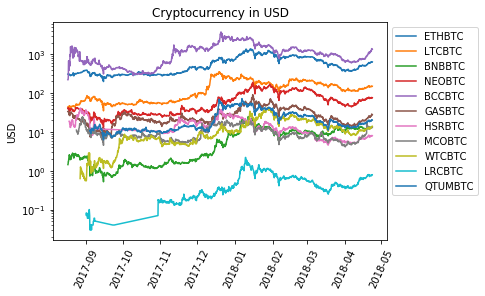

In [567]:
#Plot Cryptocurrency in USD
for k, v in btc_4hour_dict.items():
    
    plt.plot(v['Open time'], v['Usd'], label = k)
    plt.yscale('log')
    plt.xticks(rotation='65')

plt.title('Cryptocurrency in USD')
plt.ylabel('USD')
plt.legend(bbox_to_anchor=(1, 1))    
plt.show()

<h5>We can see that each coin is generally correlated. Let's try calculating the pearson correlation coefficients to help visualize.</h5> 

In [325]:
|

In [ ]:
'''plot 5 things: correlation map, '''
'''get marketcap info so we can analyze not just on price fluctuation but cap as a whole'''

In [ ]:
#do tutorial first though...maybe we can sort the lines out in above graph without plot.ly
#rewatch datacamp visualization vids
#setup github through nbviewer so plot.ly can be used

<h5>Correlation analysis</h5>


In [ ]:
'''4hour intervals would be a great starting point at identifying P&Ds'''
'''what to do when PnD is right when the intervals change? maybe its okay... we dont need all data points, 
just enough to run a machine learning algorithm ''''''

In [20]:
'''metrics to look at:
    PnD to volume ratio scatter plot
    volume to price trend scatter plot...does high volume correlate with going up or down?
    seasonality?
'''

'metrics to look at:\n    PnD to volume ratio scatter plot\n    volume to price trend scatter plot...does high volume correlate with going up or down?\n    seasonality?\n'

In [22]:
'''do usual eda then learn the datacamp financial series, cyclical trends? weekly and quarterly, monthly, 
which days a week do pnds happen?
'''

'do usual eda then learn the datacamp financial series, cyclical trends? weekly and quarterly, monthly, \nwhich days a week do pnds happen?\n'

In [23]:
'''pull all pnd data and overlay them on a graph, try to see any visual patterns'''

'pull all pnd data and overlay them on a graph, try to see any visual patterns'

In [24]:
'''find 10-15 features and see how they contribute'''

'find 10-15 features and see how they contribute'

In [26]:
'''can we pull sell/buy walls? yes but only real time?'''

'can we pull sell/buy walls? yes but only real time?'

In [562]:
'''machine learning!!'''

'machine learning!!'

In [563]:
# def clean_df_labels(df):
#     '''convert object dtypes to numeric, reset index'''
#     df = df.apply(pd.to_numeric, errors='ignore')

#     ###how to not convert datetime64 to float?? whats the best way....
#     df['Open time'] = df['Open time'].astype('datetime64[ns]')
#     df['Close time'] = df['Close time'].astype('datetime64[ns]')
#     #df.ticker = df.ticker.astype('category')
    
#     #reset index
#     #df = df.reset_index(drop =True)
    
#     return df

In [564]:
# def concat_all_pump_and_dump(df_dict, percentage = 0):
#     '''find all instances of PnD and returns a single df'''
  
#     #concatonate all dataframes inside given dictionary
#     temp_df = pd.concat(df_dict.values())
   
#     #find pump and dumps above the given percentage
#     temp_df = add_pnd_column(temp_df, percentage)
    
#     #assign dtypes, reset index
#     temp_df = clean_df_labels(temp_df)
    
#     #set index and sort by ticker and Open time
#     temp_df = temp_df.set_index(['ticker', 'Open time'])
#     temp_df.sort_index()
    
#     return temp_df